<a href="https://colab.research.google.com/github/rHarris4080/Final-Capstone/blob/main/2_Capstone_4_v4_Finally_THE_ONE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Capstone 4 v4 - The One
####Robert Harris

The freedom of the open road.  Many people truly enjoy the overall driving experience.  I personally feel engaged while driving a manual transmission on a winding country road.  Yet that same experience in stop and go urban traffic is not so pleasant.  While driving enthusiast will always have their niche, the raw idea of basic transportation is changing.  Rideshare companies like Uber and Lyft are already changing how we approach basic transportation.  Mainstream use of driverless vehicles is soon to follow.

Autonomous cars are on their way and will be an integral component to the transportation industry before too long.  The task is to make them safe, reliable, and dependable for their acceptance as a viable transportation option.
One of the major components to an autonomous car’s safety is for image recognition from the vehicle’s CPU.  Therefore, the focus of this project is to detect road signs from images taken from German roads.  The datafile of interest is “GTSRB – German Traffic Sign Recognition Benchmark” on Kaggle.com. https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign.

###Datafile:
*	Single-image, multi-class classification problem
* 43 classes
* Over 50,000 images

###Task:
Write a Deep Learning, generalized Artificial Neural Network(ANN), classification model to identify street signs.  I anticipated performing some initial data analysis, preprocessing, and proceed with fine tuning the deep learning component.  I did not foresee the the time and effort I would have to invest in accessing the data, implementing a Convolution Neural Network(CNN), and all the issues that would present themselves due to computer limitations.

###Stakeholders:
Anyone interested in safety of autonomous vehicles from auto manufacturers to government agencies to academics.  

###Challenges:
Along with the major ones discussed in the Task component, the biggest challenge for me was recognizing the power of Keras.  Initially, I was attempting to do all the raw coding before my mentor, Jakob Solomonsson, directed me to a Keras article on building a categorical classifier from scratch.  That advice refocused my direction into a big picture perspective that helped temendously. 

Another issue I had was working with all the nuances of images.  As with every project in this program, I have an idea going in without an initial full grasp of the material.  A much clearer understanding of the process has developed after investigating concepts, testing code, and researching online to gain insights. 



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


##Download and explore the dataset:
The dataset contains roughly 39k photos of 43 German traffic signs stored in 43 folders, one per categorical sign.


In [ ]:
train_path = '/content/drive/MyDrive/18-Mod32-Capstone4/gtsrb-german-traffic-sign/Train'

###Load 'train_ds' & 'val_ds' using keras.preprocessing.image_dataset_from_directory:
Converts a directory of images stored in a file to a tf.data.Dataset.
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

Notes of significance:

1. taining data is shuffled internally.
2. images and labels are encapsulated within train_ds.
3. A validation dataset is also created for convenience.

In [ ]:
import tensorflow as tf

batch_size = 32   # default
IMAGE_SIZE = 30

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split = 0.2,
    subset = "training",
    seed = 1337,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split = 0.2,
    subset = "validation",
    seed = 1337,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = batch_size
)

Found 39209 files belonging to 43 classes.
Using 31368 files for training.
Found 39209 files belonging to 43 classes.
Using 7841 files for validation.


###Investigate the dataset:
tf.data.Dataset objects 'train_ds' & 'val_ds' 
*   data - Images are a tensor of shape (32, 30, 30, 3) 
*   (batch_size, image_size[0], image_size[1], num_channels)


*   labels - tensor of shape (32,)
*   representing the corresponding sign labels for the data component.





In [ ]:
# Composition of train_ds & val_ds:
for data, labels in train_ds:
   print(data.shape)    # (32, 30, 30, 3)       NEED Test images in same dimension 
   print(data.dtype)    # float32
   print(labels.shape)  # (32,)
   print(labels.dtype)  # int32
   break

(32, 30, 30, 3)
<dtype: 'float32'>
(32,)
<dtype: 'int32'>


In [ ]:
class_names = train_ds.class_names
print(class_names)

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']


###Visualize the dataset:

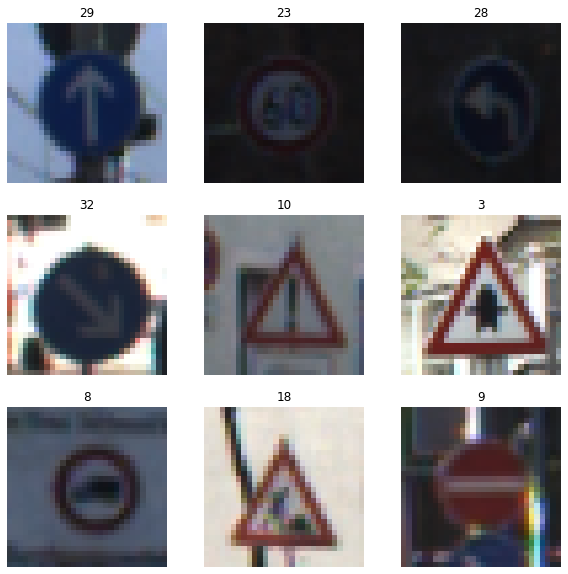

In [ ]:
# Print the first 9 images in train_ds.
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1): # take 1 batch at a time
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

###Data Augmentation:
Introduce small random rotations exposing model to different aspects of the training data.  This will help slow down overfitting.

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

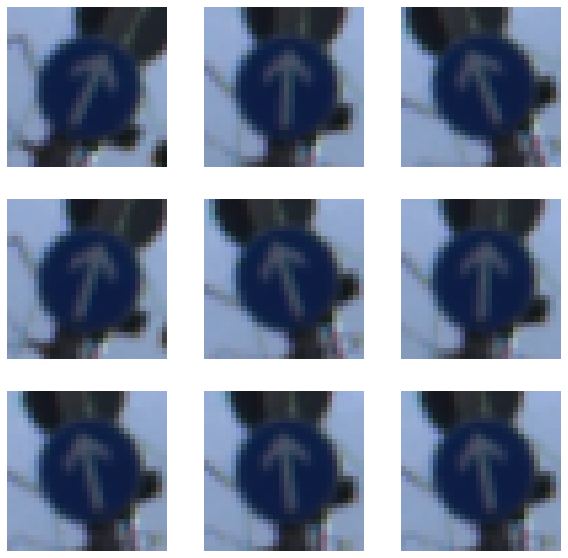

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

##Configure the dataset for performance:

*   Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.
*   Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [ ]:
#A. COLAB - CLASSIFICATION (Much slower)
#AUTOTUNE = tf.data.AUTOTUNE

#train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#B. KERAS - CLASSIFICATION FROM SCRATCH (Slower)
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

#C. NOT USED: (Much faster)

##Build the CNN model:
Added the Dropout layer to reduce the possibility of overfit.

In [ ]:
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers.experimental.preprocessing as preprocessing

num_classes=43

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
  layers.experimental.preprocessing.RandomContrast(0.6),

  #layers.Conv2D(16, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(pool_size=(2,2)),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  #layers.Dropout(0.2),

  layers.Flatten(),
  layers.Dense(128, activation='relu'),

  layers.Dense(num_classes, activation='softmax')            
])


##Compile & summarize:
###Chose 'sparse_categorical_crossentropy' over 'categorical_crossentropy' because labels are:
1. mutually exclusive.
2. not one-hot encoded.

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 30, 30, 3)         0         
_________________________________________________________________
random_contrast (RandomContr (None, 30, 30, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 7200)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               921728    
_________________________________________________________________
dense_1 (Dense)              (None, 43)                5

##Train the model:

In [ ]:
epochs=10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=32 )

Epoch 1/10
981/981 [==============================] - 4622s 5s/step - loss: 1.2807 - accuracy: 0.6689 - val_loss: 0.4457 - val_accuracy: 0.8757
Epoch 2/10
981/981 [==============================] - 81s 83ms/step - loss: 0.3235 - accuracy: 0.9198 - val_loss: 0.2404 - val_accuracy: 0.9397
Epoch 3/10
981/981 [==============================] - 81s 83ms/step - loss: 0.1933 - accuracy: 0.9536 - val_loss: 0.1838 - val_accuracy: 0.9520
Epoch 4/10
981/981 [==============================] - 84s 85ms/step - loss: 0.1356 - accuracy: 0.9657 - val_loss: 0.1548 - val_accuracy: 0.9654
Epoch 5/10
981/981 [==============================] - 79s 81ms/step - loss: 0.1103 - accuracy: 0.9705 - val_loss: 0.1528 - val_accuracy: 0.9648
Epoch 6/10
981/981 [==============================] - 79s 80ms/step - loss: 0.0810 - accuracy: 0.9783 - val_loss: 0.1447 - val_accuracy: 0.9671
Epoch 7/10
981/981 [==============================] - 78s 79ms/step - loss: 0.0728 - accuracy: 0.9808 - val_loss: 0.1364 - val_accuracy:

##Evaluate the model:

In [ ]:
val_loss, val_acc = model.evaluate(val_ds, verbose=0)
print('Val loss score:', val_loss)
print('Val accuracy:', val_acc)

Val loss score: 0.272542804479599
Val accuracy: 0.9539599418640137


##Visualize training results:

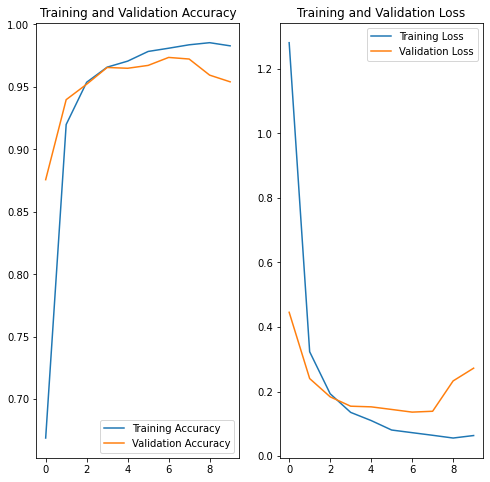

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##Running predictions:
Loading the training data through tf.keras.preprocessing.image_dataset_from_directory has many positive attributes including the internal shuffling of training data, encapsulating the images and labels, and the creation of a validation dataset as mentioned earlier.  Another advantage allows us to implement the unused Test file to check some specific predictions.



In [ ]:
from google.colab import files 
import io

uploaded = files.upload()
test_df = pd.read_csv(io.BytesIO(uploaded['Test.csv']))

Saving Test.csv to Test.csv


###Print the first 9 images in Test file:

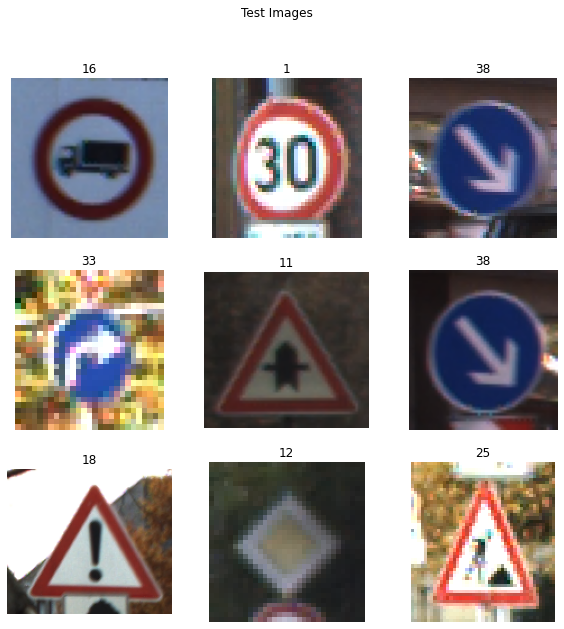

In [ ]:
from PIL import Image
from matplotlib.image import imread

data_path = '/content/drive/MyDrive/18-Mod32-Capstone4/gtsrb-german-traffic-sign'
test_img_path = data_path +'/' +test_df["Path"].values

plt.figure(figsize=(10,10))   # Adjust back to 5x5 later!
for i in range(1, 10):
  ax = plt.subplot(3,3,i)
  img = imread(test_img_path[i-1])
  plt.imshow(img)
  plt.title(test_df.iloc[i-1].ClassId)
  plt.axis("off")

plt.suptitle('Test Images')
plt.show()

In [ ]:


img = keras.preprocessing.image.load_img(test_img_path[2], target_size=(30,30))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(class_names[np.argmax(score)])

38


## Conclusions:
##TBD -Adjust the following:

###Is 99% accuracy enough for real world usage? 
Yes and no. Yes if we have an optimal environment. This means the sign needs to be well lit and not obstructed (by an object, heavy rain or snowstorm).

Although the model has a nearly perfect score with very poor images, we might need further testing. Possibly hooking it to a camera mounted in a car and see how it performs in different scenarios such as:

Night time
Heavy rain
Snow storm
Obstructed by an object
The car moving at high speed
We might also need to test at which distance does the sign needs to be from a moving car for the model to give an accurate prediction. This might help set a safety threshold where the prediction is not to be trusted unless the distance is below that threshold.

###Acknowlegements:
A huge shout-out to the many publications, youtube videos, and all the selfless individuals willing to share insights online. Specific inspiration was acquired from the following: 

*   Keras - Image Classification from Scratch
*   Colab Classification
* Youtuber - 
* Youtuber - deeplizzard
* Jakob Salamonnson - Thinkful Mentor
